In [ ]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read datasets needed (if using local files)
from google.colab import files
uploaded = files.upload()

In [ ]:
# import raw data (if using local files)
import io
study_population = pd.read_csv(io.BytesIO(uploaded['PRO-ACT_filtered.csv']))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import raw data (if using google drive)
study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/PRO-ACT_filtered.csv')
study_population = study_population.drop(['Unnamed: 0'], axis=1)
study_population

<ipython-input-4-4f8f58a6c30f>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/PRO-ACT_filtered.csv')


,SubjectID,form_name,feature_name,feature_value,feature_delta
0,348.0,Demographic,Gender,F,0.0
1,533.0,Demographic,Gender,F,0.0
2,902.0,Demographic,Gender,F,0.0
3,1736.0,Demographic,Gender,M,0.0
4,3971.0,Demographic,Gender,F,0.0
...,...,...,...,...,...
561869,999522.0,Target_variable,time_LOA,10.78,NaN
561870,999823.0,Target_variable,status_LOA,0.0,NaN
561871,999823.0,Target_variable,time_LOA,3.05,NaN
561872,999990.0,Target_variable,status_LOA,0.0,NaN


In [ ]:
print("Study population contains", len(study_population['SubjectID'].unique().tolist()), 'patients')

Study population contains 3396 patients


# 1. Extracting feature variables

## 1-1. Static features

In [ ]:
def extract_static_feature(df, feature_list):
  df_final = df[df['feature_name'] == feature_list[0]][['SubjectID', 'feature_value']].rename(columns = {'feature_value': feature_list[0]})

  del feature_list[0]
  for x in feature_list:
    df_add = df[df['feature_name'] == x][['SubjectID', 'feature_value']].rename(columns = {'feature_value': x})
    df_final = pd.merge(df_final,df_add, on=['SubjectID'], how='inner')

  return df_final

### (1) Age/Gender (Demographics)

In [ ]:
demographics = extract_static_feature(study_population, ['Age', 'Gender'] )
demographics = demographics.astype({'Age':'float'})

<Axes: xlabel='Age', ylabel='Count'>

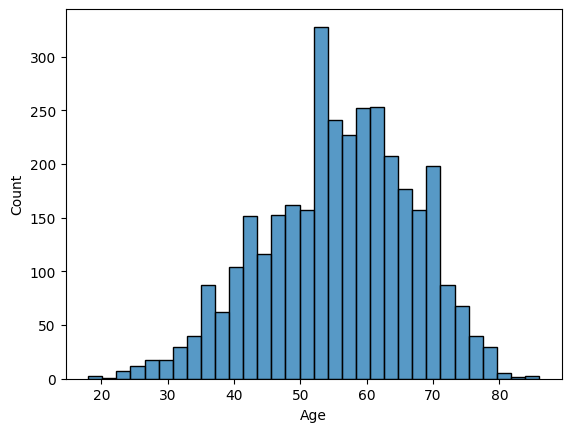

In [ ]:
sns.histplot(demographics['Age'])

In [ ]:
demographics['Age'].describe() # min = 18, max = 86

count    3396.000000
mean       55.741284
std        11.163848
min        18.000000
25%        48.000000
50%        57.000000
75%        64.000000
max        86.000000
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

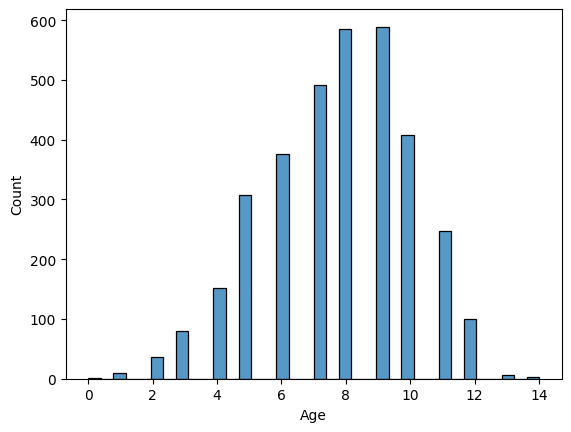

In [ ]:
# Convert 'Age' into ordered-categorical data (categorize in  5 years)  (ex. 15~19 -> "0"/ 20~24 -> "1")
age_min = 15

def cat_age(age, age_min):
  return (age - age_min) // 5

demographics['Age'] = demographics.apply(lambda x: cat_age(x['Age'], age_min), axis = 1)
sns.histplot(demographics['Age'])

In [ ]:
# Female = 0, Male = 1
demographics = demographics.replace({'Gender':{"F":0, "M":1}})
demographics #3396 data

,SubjectID,Age,Gender
0,348.0,7.0,0
1,533.0,10.0,0
2,902.0,12.0,0
3,3971.0,8.0,0
4,4752.0,3.0,1
...,...,...,...
3391,974704.0,10.0,1
3392,974907.0,10.0,0
3393,978851.0,6.0,0
3394,992560.0,3.0,1


### (2) diag_delta/onset_delta/diag_minus_onset/onset_site (ALS history)

In [ ]:
als_hx = extract_static_feature(study_population, ['diag_delta', 'onset_delta', 'onset_site'] )
als_hx = als_hx.astype({'diag_delta':'float', 'onset_delta':'float'})

# Convert scale 'days' to 'month'
als_hx['onset_delta'] = -round((als_hx['onset_delta']/365)*12,2)
als_hx['diag_delta'] = -round((als_hx['diag_delta']/365)*12,2)

#define 'diag_minus_onset' as time difference between onset and diagnosis
als_hx['diag_minus_onset'] = als_hx['diag_delta']-als_hx['onset_delta']
als_hx

# Bubar_onset = 1, non-Bulbar_onset = 0
als_hx = als_hx.replace({'onset_site':{"Other":0, "Bulbar":1, "Limb":0, "Limb and Bulbar":1}}) #Multifocal onset is included in bubar onset

## 1-2. Time-resolved features

In [ ]:
def extract_time_resolved_feature(df, feature_list):
  df_final = df[df['feature_name'] == feature_list[0]][['SubjectID', 'feature_value', 'feature_delta']].rename(columns = {'feature_value': feature_list[0]})

  del feature_list[0]
  for x in feature_list:
    df_add = df[df['feature_name'] == x][['SubjectID', 'feature_value', 'feature_delta']].rename(columns = {'feature_value': x})
    df_final = pd.merge(df_final,df_add, on=['SubjectID','feature_delta'], how='inner')

  return df_final

In [ ]:
# Define function calculating mean
def cal_mean(df):
  df_mean = df.groupby('SubjectID').agg('mean')
  df_mean.reset_index(inplace=True) # reset 'SubjectiD' as column

  mean_df = pd.DataFrame(df_mean['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    mean_df['mean_'+feature] = df_mean[feature]

  return mean_df

In [ ]:
# Define function calculating slope
def cal_slope(df):
  df_first_last = df.groupby('SubjectID').agg(['first', 'last'])
  df_first_last.reset_index(inplace=True) # reset 'SubjectiD' as column
  df_first_last['interval'] = df_first_last[('feature_delta','last')] - df_first_last[('feature_delta','first')]
  df_first_last = df_first_last[df_first_last['interval']!=0] # exclude data that is observed only once

  slope_df = pd.DataFrame(df_first_last['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    slope_df['slope_'+feature] = df_first_last.apply(lambda x: (x[(feature,'last')]-x[(feature, 'first')])/x[('interval','')] if x[('interval','')] >= 1.5 else np.nan, axis = 1)
    # data with time interval less than 1.5 month is regarded as missing data, otherwise calculate slope with data of (last, first) feature delta

  return slope_df

In [ ]:
# Define function calculating slope (Linear regression)
from sklearn.linear_model import LinearRegression
def cal_slope_LR(df):
    df_first_last = df.groupby('SubjectID').agg(['first', 'last'])
    df_first_last.reset_index(inplace=True) # reset 'SubjectiD' as column
    df_first_last['interval'] = df_first_last[('feature_delta','last')] - df_first_last[('feature_delta','first')]
    df_first_last = df_first_last[df_first_last['interval']>1.5] # exclude data that is observed only once
    df =  df.query("SubjectID == {0}".format(df_first_last['SubjectID'].unique().tolist()))

    features = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)
    result = pd.DataFrame(columns=["SubjectID"] + [f"slope_{feature}" for feature in features])
    for subject_id, subject_data in df.groupby("SubjectID"):
        slopes = []
        for feature in features:
            X = subject_data[["feature_delta"]].values
            y = subject_data[feature].values
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            slopes.append(slope)
        result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))

    return result

In [ ]:
# Define function calculating for time-resolved features
def cal_time_resolved(df):
  # Filter first 3 month data
  df_3mo = df.query('(feature_delta <= 3.0) and (feature_delta >= 0)')

  # Calculate mean
  mean_df = cal_mean(df_3mo)

  # Calculate slope
  slope_df = cal_slope_LR(df_3mo)

  # Merge mean & slope data (outer join)
  df_summary =  mean_df.merge(slope_df, on = 'SubjectID', how='outer')

  return df_summary

### (1) alsfrs_r (total/3 dimension/q)

In [ ]:
ALSFRS_R_raw = study_population.query("form_name == 'ALSFRS'").astype({'feature_delta':'float'})

In [ ]:
ALSFRS_R_raw['feature_name'].unique().tolist()

['Q1_Speech',
 'Q2_Salivation',
 'Q3_Swallowing',
 'Q4_Handwriting',
 'Q5a_Cutting_without_Gastrostomy',
 'Q5b_Cutting_with_Gastrostomy',
 'Q6_Dressing_and_Hygiene',
 'Q7_Turning_in_Bed',
 'Q8_Walking',
 'Q9_Climbing_Stairs',
 'Q10_Respiratory',
 'ALSFRS_Total',
 'ALSFRS_R_Total',
 'R_1_Dyspnea',
 'R_2_Orthopnea',
 'R_3_Respiratory_Insufficiency',
 'Q5_Cutting']

In [ ]:
feature_list = [x for x in ALSFRS_R_raw['feature_name'].unique().tolist() if x not in ['Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy', 'Q10_Respiratory', 'ALSFRS_Total']]
ALSFRS_R = extract_time_resolved_feature(ALSFRS_R_raw, feature_list)

# Define a dictionary with the new column names
new_column_names = {
    'R_1_Dyspnea': 'R1_Dyspnea',
    'R_2_Orthopnea': 'R2_Orthopnea',
    'R_3_Respiratory_Insufficiency': 'R3_Respiratory_Insufficiency'
}

# Use the rename() method to change the column names
ALSFRS_R.rename(columns=new_column_names, inplace=True)
ALSFRS_R

,SubjectID,Q1_Speech,feature_delta,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,ALSFRS_R_Total,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,Q5_Cutting
0,348.0,4.0,0.0,4.0,4.0,3.0,3.0,4.0,2.0,1.0,39.0,4.0,4.0,4.0,2.0
1,348.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
2,348.0,4.0,52.0,4.0,4.0,4.0,2.0,3.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
3,348.0,4.0,61.0,4.0,4.0,4.0,2.0,3.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
4,348.0,4.0,99.0,4.0,4.0,4.0,2.0,3.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33242,999990.0,3.0,12.0,4.0,4.0,2.0,1.0,2.0,1.0,0.0,30.0,4.0,4.0,4.0,1.0
33243,999990.0,3.0,40.0,4.0,4.0,0.0,1.0,1.0,1.0,0.0,27.0,4.0,4.0,4.0,1.0
33244,999990.0,3.0,68.0,4.0,4.0,0.0,1.0,1.0,1.0,0.0,26.0,4.0,3.0,4.0,1.0
33245,999990.0,3.0,97.0,4.0,3.0,0.0,1.0,1.0,1.0,0.0,25.0,4.0,4.0,4.0,0.0


In [ ]:
# Convert scale 'days' to 'month'
ALSFRS_R['feature_delta']=round((ALSFRS_R['feature_delta']/365)*12,2)
ALSFRS_R

,SubjectID,Q1_Speech,feature_delta,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,ALSFRS_R_Total,R1_Dyspnea,R2_Orthopnea,R3_Respiratory_Insufficiency,Q5_Cutting
0,348.0,4.0,0.00,4.0,4.0,3.0,3.0,4.0,2.0,1.0,39.0,4.0,4.0,4.0,2.0
1,348.0,4.0,0.13,4.0,4.0,3.0,2.0,4.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
2,348.0,4.0,1.71,4.0,4.0,4.0,2.0,3.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
3,348.0,4.0,2.01,4.0,4.0,4.0,2.0,3.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
4,348.0,4.0,3.25,4.0,4.0,4.0,2.0,3.0,2.0,1.0,38.0,4.0,4.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33242,999990.0,3.0,0.39,4.0,4.0,2.0,1.0,2.0,1.0,0.0,30.0,4.0,4.0,4.0,1.0
33243,999990.0,3.0,1.32,4.0,4.0,0.0,1.0,1.0,1.0,0.0,27.0,4.0,4.0,4.0,1.0
33244,999990.0,3.0,2.24,4.0,4.0,0.0,1.0,1.0,1.0,0.0,26.0,4.0,3.0,4.0,1.0
33245,999990.0,3.0,3.19,4.0,3.0,0.0,1.0,1.0,1.0,0.0,25.0,4.0,4.0,4.0,0.0


In [ ]:
# Create meta-feature "Bulbar"; Q2 score was excluded from bulbar score because salivation can be easily affected by drug usage
ALSFRS_R = ALSFRS_R.astype('float')
ALSFRS_R['bulbar'] = ALSFRS_R['Q1_Speech'] + ALSFRS_R['Q3_Swallowing']

In [ ]:
# Create meta-feature "motor"
ALSFRS_R['motor'] = ALSFRS_R['Q4_Handwriting'] + ALSFRS_R['Q5_Cutting'] + ALSFRS_R['Q6_Dressing_and_Hygiene'] + ALSFRS_R['Q7_Turning_in_Bed'] + ALSFRS_R['Q8_Walking'] + ALSFRS_R['Q9_Climbing_Stairs']
ALSFRS_R['respiratory_R'] = ALSFRS_R['R1_Dyspnea'] + ALSFRS_R['R2_Orthopnea'] + ALSFRS_R['R3_Respiratory_Insufficiency']

In [ ]:
# Calculate
alsfrs_R_summary = cal_time_resolved(ALSFRS_R)
alsfrs_R_summary #3396 data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append

,SubjectID,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_ALSFRS_R_Total,...,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_ALSFRS_R_Total,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_Q5_Cutting,slope_bulbar,slope_motor,slope_respiratory_R
0,348.0,4.00,4.000000,4.00,3.500000,2.250000,3.500000,2.000000,1.000000,38.250000,...,0.000000,0.000000,-0.293851,0.000000,0.000000,0.0,0.000000,0.000000,-0.293851,0.000000
1,533.0,1.00,1.333333,2.00,4.000000,3.333333,4.000000,3.333333,2.666667,36.666667,...,0.352632,0.631458,0.065606,0.000000,0.000000,0.0,0.000000,-0.492045,0.770871,0.000000
2,902.0,4.00,3.750000,3.25,4.000000,2.750000,4.000000,2.500000,1.000000,40.250000,...,-0.434783,0.000000,-1.195652,-0.434783,0.000000,0.0,0.000000,0.326087,-1.195652,-0.434783
3,1736.0,2.50,3.000000,3.00,1.500000,1.000000,0.500000,0.500000,0.000000,24.500000,...,-0.632911,0.000000,-3.164557,0.632911,0.000000,0.0,0.000000,-0.632911,-1.898734,0.632911
4,3971.0,4.00,4.000000,4.00,4.000000,2.000000,3.000000,1.000000,0.000000,38.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3391,998491.0,3.00,3.500000,3.75,3.000000,2.750000,2.000000,2.000000,1.250000,36.500000,...,0.000000,-0.824911,-0.704097,0.000000,0.000000,0.0,0.352049,0.305282,-0.824911,0.000000
3392,999166.0,3.00,3.000000,4.00,4.000000,4.000000,3.000000,3.000000,3.000000,43.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3393,999522.0,4.00,4.000000,4.00,4.000000,3.000000,3.000000,2.000000,1.000000,40.800000,...,0.000000,0.000000,0.055136,0.055136,0.000000,0.0,0.000000,0.000000,0.000000,0.055136
3394,999823.0,2.75,3.000000,2.75,4.000000,3.000000,4.000000,4.000000,4.000000,43.250000,...,0.000000,0.000000,-0.775298,0.000000,0.000000,0.0,-0.120494,-0.654804,-0.120494,0.000000


### (2) FVC

In [ ]:
FVC_raw = study_population.query("feature_name == 'fvc_percent'").astype({'feature_delta':'float'})

In [ ]:
feature_list2 = [x for x in FVC_raw['feature_name'].unique().tolist()]
FVC = extract_time_resolved_feature(FVC_raw, feature_list2)
FVC

,SubjectID,fvc_percent,feature_delta
496091,533.0,76.94444444444446,0.0
496092,533.0,69.95833333333333,12.0
496093,902.0,89.66666666666667,0.0
496094,902.0,92.0,7.0
496095,902.0,89.33333333333333,35.0
...,...,...,...
510267,999990.0,88.33333333333333,12.0
510268,999990.0,82.66666666666667,40.0
510269,999990.0,85.66666666666667,68.0
510270,999990.0,81.0,97.0


In [ ]:
FVC = FVC.astype('float')

# Convert scale 'days' to 'month'
FVC['feature_delta']=round((FVC['feature_delta']/365)*12,2)
FVC.columns = ['SubjectID','fvc', 'feature_delta']

In [ ]:
# Calculate
fvc_summary = cal_time_resolved(FVC)
fvc_summary.columns = ['SubjectID','mean_fvc', 'slope_fvc']
fvc_summary # 2141 data

<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes

,SubjectID,mean_fvc,slope_fvc
0,533.0,73.451389,NaN
1,902.0,89.400000,-1.283922
2,1736.0,71.333333,0.000000
3,3971.0,85.790970,NaN
4,4752.0,82.111111,1.283114
...,...,...,...
2136,996981.0,90.979381,-0.931190
2137,997829.0,85.571405,-4.767236
2138,999166.0,74.666667,NaN
2139,999823.0,100.600000,-0.333391


### (3) Creatinine

In [ ]:
creatinine = extract_time_resolved_feature(study_population, ['creatinine'] )

# Check string value
creatinine[creatinine['creatinine']=='<18'] #There are subjects with string value '<18'

,SubjectID,creatinine,feature_delta
513261,115061.0,<18,103.0
513262,115061.0,<18,221.0
513263,115061.0,<18,397.0
513264,115061.0,<18,412.0
513265,115061.0,<18,440.0
514767,164377.0,<18,402.0
518365,301061.0,<18,404.0
523569,499546.0,<18,438.0
524729,539505.0,<18,379.0
524731,539505.0,<18,434.0


In [ ]:
#Exclude subjects with string value
creatinine = creatinine[creatinine['creatinine'] != '<18']

In [ ]:
creatinine = creatinine.astype('float')

# Convert scale 'days' to 'month'
creatinine['feature_delta']=round((creatinine['feature_delta']/365)*12,2)
creatinine

,SubjectID,creatinine,feature_delta
510272,348.0,53.04,0.00
510273,348.0,53.04,0.62
510274,348.0,53.04,2.01
510275,348.0,53.04,2.96
510276,348.0,61.88,3.95
...,...,...,...
537863,999990.0,53.04,1.74
537864,999990.0,44.20,2.24
537865,999990.0,44.20,2.70
537866,999990.0,44.20,3.19


In [ ]:
# Calculate
creatinine_summary = cal_time_resolved(creatinine)
creatinine_summary # 3039 data

<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes

,SubjectID,mean_creatinine,slope_creatinine
0,348.0,53.0400,0.000000
1,533.0,79.5600,0.000000
2,1736.0,58.4000,-0.703942
3,3971.0,53.0400,NaN
4,4096.0,51.2820,-3.138323
...,...,...,...
3034,997829.0,53.0000,NaN
3035,998491.0,57.4725,-0.628392
3036,999166.0,83.9800,5.854305
3037,999522.0,65.0000,-3.842884


### (4) Weight

In [ ]:
weight = extract_time_resolved_feature(study_population, ['weight'] )
weight = weight.astype('float')

# Convert scale 'days' to 'month'
weight['feature_delta']=round((weight['feature_delta']/365)*12,2)
weight

,SubjectID,weight,feature_delta
537868,348.0,118.8,0.00
537869,348.0,118.8,0.62
537870,348.0,122.5,2.01
537871,348.0,118.4,6.61
537872,348.0,117.9,8.22
...,...,...,...
555077,999990.0,56.7,0.85
555078,999990.0,56.7,1.32
555079,999990.0,56.7,2.24
555080,999990.0,56.2,3.19


In [ ]:
# Calculate
weight_summary = cal_time_resolved(weight)
weight_summary # 2630 data

<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes], columns=result.columns))
<ipython-input-16-210f4df861d6>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame([[subject_id] + slopes

,SubjectID,mean_weight,slope_weight
0,348.0,120.033333,1.979045
1,533.0,51.000000,-0.228993
2,902.0,62.220000,-0.443537
3,1736.0,121.400000,NaN
4,3971.0,88.900000,-1.500000
...,...,...,...
2625,996981.0,85.000000,NaN
2626,997829.0,57.900000,NaN
2627,999166.0,84.750000,NaN
2628,999823.0,70.460000,-0.618819


## 1-3. Merging all features

In [ ]:
# Outer join all features to allow missing data
features_df = pd.DataFrame(columns=['SubjectID'])
feature_list = [demographics, als_hx, alsfrs_R_summary,fvc_summary, creatinine_summary, weight_summary]
for i in feature_list :
    df = i
    features_df = features_df.merge(df, on='SubjectID', how='outer')
features_df #3396 data

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,...,slope_Q5_Cutting,slope_bulbar,slope_motor,slope_respiratory_R,mean_fvc,slope_fvc,mean_creatinine,slope_creatinine,mean_weight,slope_weight
0,348.0,7.0,0,9.93,16.47,0,-6.54,4.0,4.000000,4.00,...,0.000000,0.000000,-0.293851,0.000000,NaN,NaN,53.04,0.000000,120.033333,1.979045
1,533.0,10.0,0,1.45,33.63,1,-32.18,1.0,1.333333,2.00,...,0.000000,-0.492045,0.770871,0.000000,73.451389,NaN,79.56,0.000000,51.000000,-0.228993
2,902.0,12.0,0,1.61,16.90,0,-15.29,4.0,3.750000,3.25,...,0.000000,0.326087,-1.195652,-0.434783,89.400000,-1.283922,NaN,NaN,62.220000,-0.443537
3,3971.0,8.0,0,12.43,25.08,0,-12.65,4.0,4.000000,4.00,...,NaN,NaN,NaN,NaN,85.790970,NaN,53.04,NaN,88.900000,-1.500000
4,4752.0,3.0,1,-0.00,3.78,0,-3.78,3.0,3.500000,3.00,...,-0.534759,0.000000,-2.673797,0.000000,82.111111,1.283114,97.24,13.082902,80.733333,3.341667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3391,974704.0,10.0,1,18.15,29.56,0,-11.41,3.0,3.500000,3.50,...,0.000000,-0.561798,-1.123596,0.000000,83.666667,-2.996255,60.20,0.697338,86.933333,-0.030069
3392,974907.0,10.0,0,6.94,19.86,0,-12.92,2.5,2.500000,3.00,...,NaN,NaN,NaN,NaN,45.000000,NaN,76.40,0.229755,72.900000,NaN
3393,978851.0,6.0,0,2.33,12.39,0,-10.06,4.0,4.000000,4.00,...,0.000000,0.000000,0.000000,0.000000,82.666667,1.473297,49.40,1.597030,47.466667,-0.225194
3394,992560.0,3.0,1,3.06,7.00,1,-3.94,1.5,4.000000,2.00,...,0.000000,0.584795,-0.584795,0.000000,70.000000,17.153996,74.60,0.154379,96.333333,-0.469212


# 2. Merging with target variable

## 2-1. extract target data

In [ ]:
Target = extract_static_feature(study_population, ['time_LOA', 'status_LOA'] )
Target # 3396 data

,SubjectID,time_LOA,status_LOA
0,348.0,10.18,0.0
1,533.0,6.4399999999999995,1.0
2,902.0,2.0599999999999996,0.0
3,1736.0,5.02,1.0
4,3971.0,9.43,0.0
...,...,...,...
3391,998491.0,1.4100000000000001,0.0
3392,999166.0,9.82,0.0
3393,999522.0,10.78,0.0
3394,999823.0,3.05,0.0


## 2-2. merge feature & target

In [ ]:
Features_and_Target_final = features_df.merge(Target, on='SubjectID', how='outer')
Features_and_Target_final.sort_values(by='SubjectID', ascending=True, inplace=True)
Features_and_Target_final

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,...,slope_motor,slope_respiratory_R,mean_fvc,slope_fvc,mean_creatinine,slope_creatinine,mean_weight,slope_weight,time_LOA,status_LOA
0,348.0,7.0,0,9.93,16.47,0,-6.54,4.00,4.000000,4.00,...,-0.293851,0.000000,NaN,NaN,53.0400,0.000000,120.033333,1.979045,10.18,0.0
1,533.0,10.0,0,1.45,33.63,1,-32.18,1.00,1.333333,2.00,...,0.770871,0.000000,73.451389,NaN,79.5600,0.000000,51.000000,-0.228993,6.4399999999999995,1.0
2,902.0,12.0,0,1.61,16.90,0,-15.29,4.00,3.750000,3.25,...,-1.195652,-0.434783,89.400000,-1.283922,NaN,NaN,62.220000,-0.443537,2.0599999999999996,0.0
2919,1736.0,5.0,1,16.80,18.74,0,-1.94,2.50,3.000000,3.00,...,-1.898734,0.632911,71.333333,0.000000,58.4000,-0.703942,121.400000,NaN,5.02,1.0
3,3971.0,8.0,0,12.43,25.08,0,-12.65,4.00,4.000000,4.00,...,NaN,NaN,85.790970,NaN,53.0400,NaN,88.900000,-1.500000,9.43,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,998491.0,11.0,1,1.08,33.24,0,-32.16,3.00,3.500000,3.75,...,-0.824911,0.000000,NaN,NaN,57.4725,-0.628392,NaN,NaN,1.4100000000000001,0.0
2485,999166.0,9.0,1,1.61,32.84,1,-31.23,3.00,3.000000,4.00,...,NaN,NaN,74.666667,NaN,83.9800,5.854305,84.750000,NaN,9.82,0.0
2905,999522.0,6.0,1,7.63,12.16,0,-4.53,4.00,4.000000,4.00,...,0.000000,0.055136,NaN,NaN,65.0000,-3.842884,NaN,NaN,10.78,0.0
2486,999823.0,7.0,1,2.76,16.18,0,-13.42,2.75,3.000000,2.75,...,-0.120494,0.000000,100.600000,-0.333391,NaN,NaN,70.460000,-0.618819,3.05,0.0


Save as

In [ ]:
Features_and_Target_final.to_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_with_NaNs.csv')

# 3. Missing data proportion check

The column slope_Q1_Speech has 475 null values. It is 13.99% of total rows.
The column slope_Q1_Speech is of type float64.

The column slope_Q2_Salivation has 475 null values. It is 13.99% of total rows.
The column slope_Q2_Salivation is of type float64.

The column slope_Q3_Swallowing has 475 null values. It is 13.99% of total rows.
The column slope_Q3_Swallowing is of type float64.

The column slope_Q4_Handwriting has 475 null values. It is 13.99% of total rows.
The column slope_Q4_Handwriting is of type float64.

The column slope_Q6_Dressing_and_Hygiene has 475 null values. It is 13.99% of total rows.
The column slope_Q6_Dressing_and_Hygiene is of type float64.

The column slope_Q7_Turning_in_Bed has 475 null values. It is 13.99% of total rows.
The column slope_Q7_Turning_in_Bed is of type float64.

The column slope_Q8_Walking has 475 null values. It is 13.99% of total rows.
The column slope_Q8_Walking is of type float64.

The column slope_Q9_Climbing_Stairs has 475 null values. It 

['slope_fvc', 'slope_creatinine', 'slope_weight']

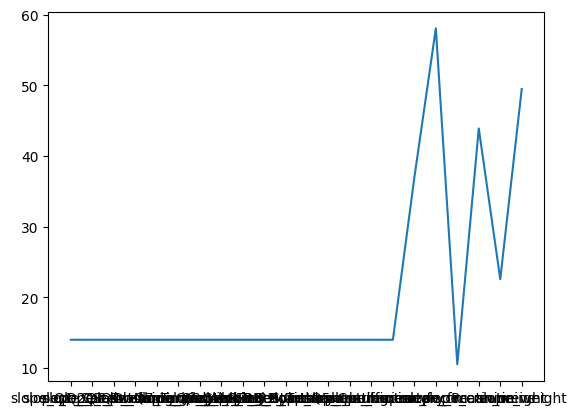

In [ ]:
def report_nulls(df):
    '''
    Show a fast report of the DF.
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    null_cols = 0
    list_of_nulls_cols = []
    list_of_nulls_cols_pcn = []
    list_of_nulls_cols_over40 = []
    for col in list(df.columns):
        null_values_rows = df[col].isnull().sum()
        null_rows_pcn = round(((null_values_rows)/rows)*100, 2)
        col_type = df[col].dtype
        if null_values_rows > 0:
            print("The column {} has {} null values. It is {}% of total rows.".format(col, null_values_rows, null_rows_pcn))
            print("The column {} is of type {}.\n".format(col, col_type))
            null_cols += 1
            list_of_nulls_cols.append(col)
            list_of_nulls_cols_pcn.append(null_rows_pcn)
            if null_rows_pcn > 40:
                list_of_nulls_cols_over40.append(col)
    null_cols_pcn = round((null_cols/columns)*100, 2)
    print("The DataFrame has {} columns with null values. It is {}% of total columns.".format(null_cols, null_cols_pcn))
    plt.plot(list_of_nulls_cols, list_of_nulls_cols_pcn)
    return list_of_nulls_cols_over40

report_nulls(Features_and_Target_final)
# ['slope_fvc', 'slope_Creatinine', 'slope_weight'] columns have missing data more than 40% and would be eliminated in feature selection